<a href="https://colab.research.google.com/github/Prabhu-bit/NEURAL-STYLE-TRANSFER/blob/main/NEURAL_STYLE_TRANSFER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()





Saving The_Great_Wave_off_Kanagawa.jpg to The_Great_Wave_off_Kanagawa (1).jpg
Saving Broadway_and_Times_Square_by_night.jpg to Broadway_and_Times_Square_by_night (1).jpg


In [ ]:
!pip install some_library


In [ ]:
content = load_image("Broadway_and_Times_Square_by_night.jpg")
style = load_image("The_Great_Wave_off_Kanagawa.jpg")

ModuleNotFoundError: No module named 'some_library'

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Step 100, Total loss: 596753856.0


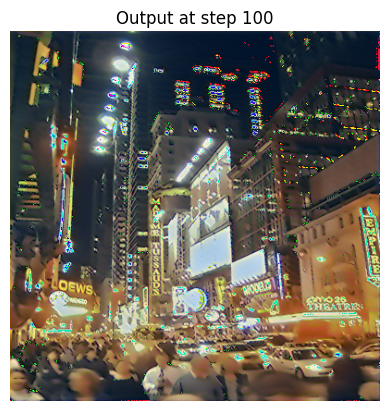

Step 200, Total loss: 275684544.0


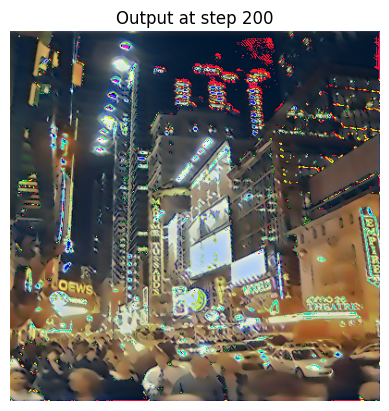

Step 300, Total loss: 205904272.0


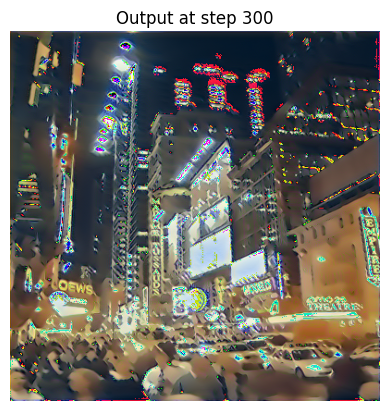

Step 400, Total loss: 169057936.0


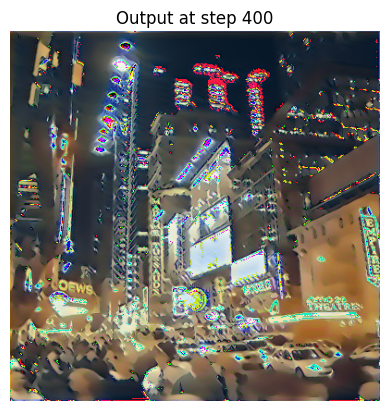

Step 500, Total loss: 144517056.0


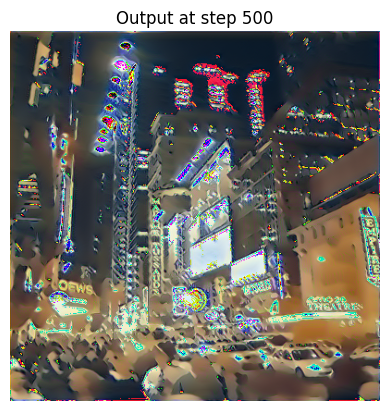

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

# Load image helper
def load_image(img_path, max_size=400):
    image = Image.open(img_path).convert('RGB')
    size = min(max(image.size), max_size)
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor()
    ])
    image = transform(image).unsqueeze(0)
    return image.to(device)

# Display helper
def imshow(tensor, title=None):
    image = tensor.cpu().clone().squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load images
content = load_image("Broadway_and_Times_Square_by_night.jpg").to(device)
style = load_image("The_Great_Wave_off_Kanagawa.jpg").to(device)

# Load pre-trained VGG19
vgg = models.vgg19(pretrained=True).features.to(device).eval()

# Loss layers
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# Model to get style/content features
# Added `detach_features` parameter
def get_features(image, model, layers=None, detach_features=True):
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if f'conv_{name}' in layers:
            if detach_features: # Only detach if requested
                features[f'conv_{name}'] = x.detach()
            else:
                features[f'conv_{name}'] = x
    return features


# Gram matrix for style
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    # Need to handle the case where the input tensor requires grad
    if tensor.requires_grad:
         gram = torch.mm(tensor, tensor.t())
    else:
        gram = torch.mm(tensor, tensor.t())
    return gram


# Get features for content and style (these should be detached)
content_features = get_features(content, vgg, content_layers, detach_features=True)
style_features = get_features(style, vgg, style_layers, detach_features=True)

# Compute style gram matrices (from detached style features)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Generate target image
target = content.clone().requires_grad_(True).to(device)

# Optimizer
optimizer = optim.Adam([target], lr=0.003)

# Style weights
style_weights = {'conv_1': 1.0, 'conv_2': 0.75, 'conv_3': 0.5, 'conv_4': 0.25, 'conv_5': 0.1}
content_weight = 1e4
style_weight = 1e2

# Training loop
for i in range(1, 501):
    # Get features for the target image (these should NOT be detached)
    target_features = get_features(target, vgg, list(style_weights.keys()) + content_layers, detach_features=False)

    # Ensure content_features are used in a way that allows computation of loss without needing their grad
    # Since content_features are detached, this subtraction and squaring is fine.
    content_loss = torch.mean((target_features['conv_4'] - content_features['conv_4'])**2)

    style_loss = 0
    for layer in style_weights:
        # Gram matrix of target_features should track gradients
        target_gram = gram_matrix(target_features[layer])
        # style_grams are from detached features, so this subtraction is fine.
        style_gram = style_grams[layer]
        layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_loss

    total_loss = content_weight * content_loss + style_weight * style_loss
    optimizer.zero_grad()
    # Now total_loss should have a grad_fn because target_features were not detached
    total_loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(f"Step {i}, Total loss: {total_loss.item()}")
        imshow(target, title=f"Output at step {i}")